In [2]:
from thermal_tank.simple_ice_tank import IceTank

In [3]:
from mpc import *
import matplotlib.pyplot as plt

# run the MPC control scheme in the Tank Model

from thermal_tank.tank_bypass_branch import TankBypassBranch

def run_tank_model(mass_flow, inlet_temp, outlet_settemp, verbose=False):
    b = TankBypassBranch(num_tanks=1, tank_data=tank_data)

    icemass = []
    tanktemp = []
    branchtemp = []
    outlettemp = []
    soc = []
    bypassfrac = []
    i = 0
    for i in range(len(mass_flow)):
        b.simulate(inlet_temp=inlet_temp[i],
                   mass_flow_rate=4.4963,
                   env_temp=20,
                   branch_set_point=outlet_settemp[i],
                   op_mode=1,
                   sim_time=i,
                   timestep=60)
        icemass.append(b.tank.ice_mass / b.tank.total_fluid_mass)
        tanktemp.append(b.tank.tank_temp)
        outlettemp.append(b.tank.outlet_fluid_temp)
        soc.append(b.tank.state_of_charge)
        branchtemp.append(b.outlet_temp)
        bypassfrac.append((1-b.bypass_fraction))
        if verbose:
            print(inlet_temp[i], b.tank.tank_temp, (1-b.bypass_fraction) * 4.4963, (1-b.bypass_fraction), b.outlet_temp, b.tank.outlet_fluid_temp)
    #     print(b.tank.state_of_charge)
        i += 1
    return tanktemp, outlettemp, branchtemp, bypassfrac


def run_and_plot(m):
#     print(degrees_of_freedom(m))
    solver = SolverFactory("ipopt")
    solver.solve(m, tee=False)
    tank_temp, mass_flow, q_tot, outlet_temp, bypass_frac, inlet_temp, outlet_settemp = get_var_values(m)   
    tank_temp_sim, outlet_temp_sim, branch_temp_sim, bypass_frac_sim = run_tank_model(mass_flow, inlet_temp, outlet_settemp)
    fig = plt.figure(figsize=(16, 5))
    plt.plot(tank_temp, 'b:', label="tank temp control")
    plt.plot(tank_temp_sim, 'b-', label="tank temp sim")
    plt.plot(outlet_temp_sim, 'k-', label="outlet temp sim")
    plt.plot(outlet_temp, 'g:', label="branch temp control")
    plt.plot(branch_temp_sim, 'g-', label="branch temp sim")
    plt.xlabel("Min")
    plt.ylabel("C")
    plt.legend()
    plt.grid()
    plt.show()
    
    res = {
        "tank_temp": tank_temp,
        "tank_temp_sim": tank_temp_sim,
        "mass_flow": mass_flow,
        "outlet_temp": outlet_temp,
        "outlet_temp_sim": outlet_temp_sim
    }
    
    return res

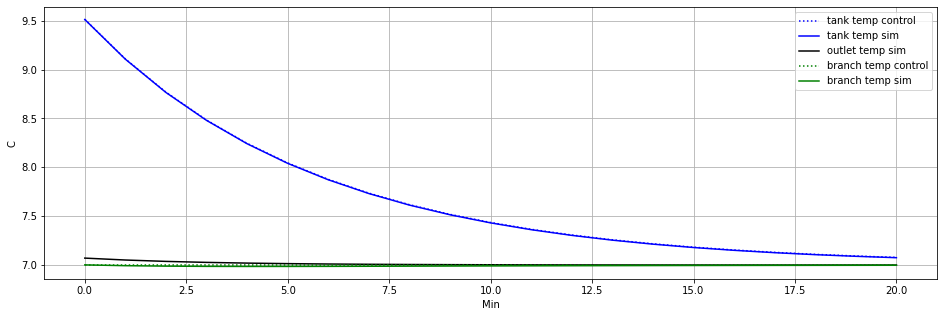

In [4]:
n = 20
m, tank = full_model(n)

m.obj = Objective(expr=m.tank_temp[n], sense=1)
m.tank_temp[-1].fix(tank.tank_temp)
m.ice_mass.fix(tank.ice_mass)
for i in range(n + 1):
    m.outlet_settemp[i].fix(7)

res = run_and_plot(m)

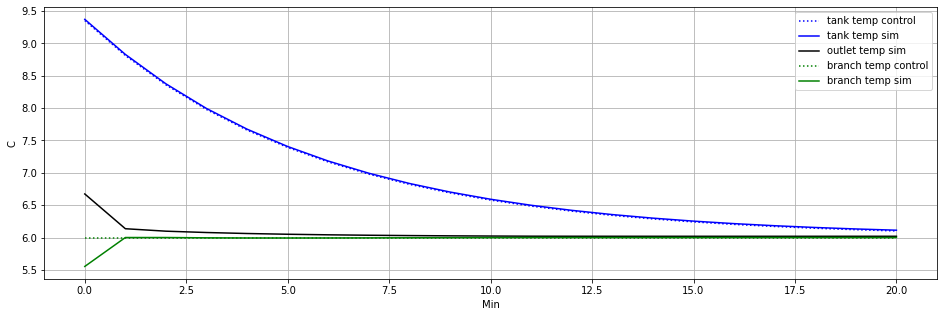

146.29760575010494


In [5]:
n = 20
m, tank = full_model(n)

m.obj = Objective(expr=summation(m.tank_temp), sense=1)
m.tank_temp[-1].fix(tank.tank_temp)
m.ice_mass.fix(tank.ice_mass)
for i in range(n + 1):
    m.outlet_settemp[i].fix(6)

res = run_and_plot(m)
print(sum(res['tank_temp']))

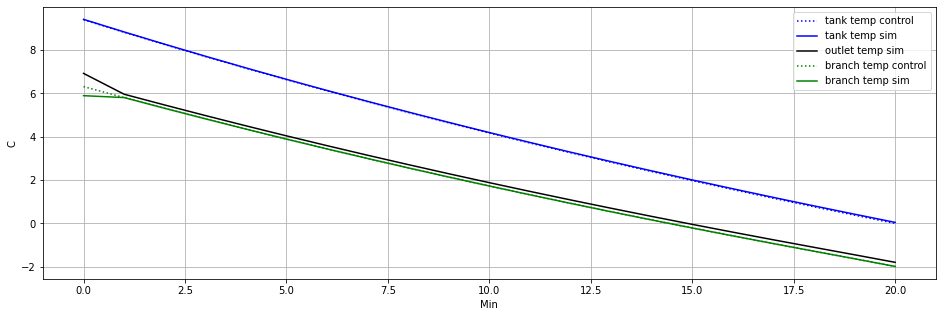

91.73950773213777


In [9]:
# Make the tank as cold as possible at the end of the timestep (but above 0 C)

n = 20
m, tank = full_model(n)

m.obj = Objective(expr=m.tank_temp[n], sense=1)
m.tank_temp[-1].fix(tank.tank_temp)
m.ice_mass.fix(tank.ice_mass)
m.tank_temp.setlb(0)
for i in range(n + 1):
    m.tank_bypass_fraction[i].fix(0)

res = run_and_plot(m)
print(sum(res['tank_temp']))

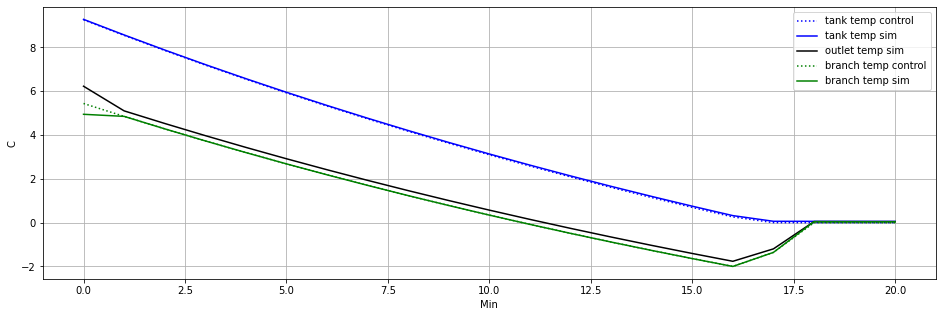

74.70779049845855


In [14]:
# Reduce the tank temp as fast as possible to 0 C

n = 20
m, tank = full_model(n)

m.obj = Objective(expr=summation(m.tank_temp), sense=1)
m.tank_temp[-1].fix(tank.tank_temp)
m.ice_mass.fix(tank.ice_mass)
m.tank_temp.setlb(0)
for i in range(n + 1):
    m.tank_bypass_fraction[i].fix(0)

res = run_and_plot(m)
print(sum(res['tank_temp']))

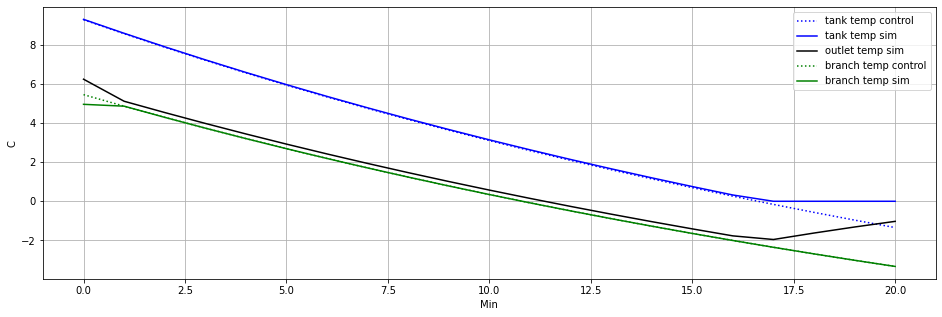

71.67806569010541


In [11]:
# Reduce the tank temp as low as possible-- runs into divergence from simulation due to phase change at 0C

n = 20
m, tank = full_model(n)

m.obj = Objective(expr=m.tank_temp[n], sense=1)
m.tank_temp[-1].fix(tank.tank_temp)
m.ice_mass.fix(tank.ice_mass)
for i in range(n + 1):
    m.tank_bypass_fraction[i].fix(0)

res = run_and_plot(m)
print(sum(res['tank_temp']))